Objective of this notebook is to break down the multivariate interpolation layer from the paper, so that I can run physiological time series through it

In [1]:
import argparse
import numpy as np
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score as auprc
from sklearn.metrics import roc_auc_score as auc_score
import keras
#from keras.utils import multi_gpu_model
from keras.layers import Input, Dense, GRU, Lambda, Permute
from keras.models import Model
from interpolation_layer import single_channel_interp, cross_channel_interp
from mimic_preprocessing import load_data, trim_los, fix_input_format
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

np.random.seed(10)

## Helper functions

In [2]:
def hold_out(mask, perc=0.2):
    """To implement the autoencoder component of the loss, we introduce a set
    of masking variables mr (and mr1) for each data point. If drop_mask = 0,
    then we remove the data point as an input to the interpolation network,
    and includecthe predicted value at this time point when assessing
    the autoencoder loss. In practice, we randomly select 20% of the
    observed data points to hold out from
    every input time series."""
    drop_mask = np.ones_like(mask)
    drop_mask *= mask
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            count = np.sum(mask[i, j], dtype='int')
            if int(0.20*count) > 1:
                index = 0
                r = np.ones((count, 1))
                b = np.random.choice(count, int(0.20*count), replace=False)
                r[b] = 0
                for k in range(mask.shape[2]):
                    if mask[i, j, k] > 0:
                        drop_mask[i, j, k] = r[index]
                        index += 1
    return drop_mask

In [3]:
def mean_imputation(vitals, mask):
    """For the time series missing entirely, our interpolation network 
    assigns the starting point (time t=0) value of the time series to 
    the global mean before applying the two-layer interpolation network.
    In such cases, the first interpolation layer just outputs the global
    mean for that channel, but the second interpolation layer performs 
    a more meaningful interpolation using the learned correlations from
    other channels."""
    counts = np.sum(np.sum(mask, axis=2), axis=0)
    mean_values = np.sum(np.sum(vitals*mask, axis=2), axis=0)/counts
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if np.sum(mask[i, j]) == 0:
                mask[i, j, 0] = 1
                vitals[i, j, 0] = mean_values[j]
    return

## Arguments

In [38]:
gpu_num = 1
epoch = 10
hid = 512
ref_points = 128
hours_look_ahead = 48
if gpu_num > 0:
    batch = 512*gpu_num
else:
    batch = 512
    
#nicks notes args
vocabulary = 6000

## Loading Data
adjust # of patients in mimic_preprocessing.py

In [9]:
# Loading dataset
# y : (N,) discrete for classification, real values for regression
# x : (N, D, tn) input multivariate time series data with dimension
#     where N is number of data cases, D is the dimension of
#     sparse and irregularly sampled time series and tn is the union
#     of observed time stamps in all the dimension for a data case n.
#     Since each tn is of variable length, we pad them with zeros to# Loading dataset
# y : (N,) discrete for classification, real values for regression
# x : (N, D, tn) input multivariate time series data with dimension
#     where N is number of data cases, D is the dimension of
#     sparse and irregularly sampled time series and tn is the union
#     of observed time stamps in all the dimension for a data case n.
#     Since each tn is of variable length, we pad them with zeros to
#     have an array representation.
# m : (N, D, tn) where m[i,j,k] = 0 means that x[i,j,k] is not observed.
# T : (N, D, tn) represents the actual time stamps of observation;

vitals, label = load_data()
vitals, timestamps = trim_los(vitals, hours_look_ahead)
x, m, T = fix_input_format(vitals, timestamps)
mean_imputation(x, m)
x = np.concatenate((x, m, T, hold_out(m)), axis=1)  # input format
y = np.array(label)
print(f"X shape: {x.shape}, Y shape: {y.shape}")
timestamp = x.shape[2]
num_features = x.shape[1] // 4
#     have an array representation.
# m : (N, D, tn) where m[i,j,k] = 0 means that x[i,j,k] is not observed.
# T : (N, D, tn) represents the actual time stamps of observation;

vitals, label = load_data()
vitals, timestamps = trim_los(vitals, hours_look_ahead)
x, m, T = fix_input_format(vitals, timestamps)
mean_imputation(x, m)
x = np.concatenate((x, m, T, hold_out(m)), axis=1)  # input format
y = np.array(label)
print(f"X shape: {x.shape}, Y shape: {y.shape}")
timestamp = x.shape[2]
num_features = x.shape[1] // 4

import pickle
patient_notes = pickle.load(open('notes_1000.p', 'rb'))[:len(label)]

Loading files ...
Loading Done with 1000 patients! Nick
920 920
(920, 12, 200) 920
X shape: (920, 48, 200), Y shape: (920,)
Loading files ...
Loading Done with 1000 patients! Nick
920 920
(920, 12, 200) 920
X shape: (920, 48, 200), Y shape: (920,)


In [49]:
def customloss(ytrue, ypred):
    """ Autoencoder loss
    """
    # standard deviation of each feature mentioned in paper for MIMIC_III data
    wc = np.array([3.33, 23.27, 5.69, 22.45, 14.75, 2.32,
                   3.75, 1.0, 98.1, 23.41, 59.32, 1.41])
    wc.shape = (1, num_features)
    y = ytrue[:, :num_features, :]
    m2 = ytrue[:, 3*num_features:4*num_features, :]
    m2 = 1 - m2
    m1 = ytrue[:, num_features:2*num_features, :]
    m = m1*m2
    ypred = ypred[:, :num_features, :]
    x = (y - ypred)*(y - ypred)
    x = x*m
    count = tf.reduce_sum(m, axis=2)
    count = tf.where(count > 0, count, tf.ones_like(count))
    x = tf.reduce_sum(x, axis=2)/count
    x = x/(wc**2)  # dividing by standard deviation
    x = tf.reduce_sum(x, axis=1)/num_features
    return tf.reduce_mean(x)

seed = 0
results = {}
results['loss'] = []
results['auc'] = []
results['acc'] = []
results['auprc'] = []

# interpolation-prediction network


def interp_net():
    if gpu_num > 1:
        dev = "/cpu:0"
    else:
        dev = "/gpu:0"
    with tf.device(dev):
        main_input = Input(shape=(4*num_features, timestamp), name='input')
        notes_input = Input(shape=(vocabulary), name='notes_input')
        sci = single_channel_interp(ref_points, hours_look_ahead)
        cci = cross_channel_interp()
        interp = cci(sci(main_input))
        reconst = cci(sci(main_input, reconstruction=True),
                      reconstruction=True)
        aux_output = Lambda(lambda x: x, name='aux_output')(reconst)
        z = Permute((2, 1))(interp)
        z = GRU(hid, activation='tanh', recurrent_dropout=0.2, dropout=0.2)(z)
        main_output = Dense(1, activation='sigmoid', name='main_output')(z)
        orig_model = Model([main_input, notes_input], [main_output, aux_output])
    if gpu_num > 1:
        model = multi_gpu_model(orig_model, gpus=gpu_num)
    else:
        model = orig_model
    #print(orig_model.summary())
    return model

earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0000, patience=20, verbose=0)
callbacks_list = [earlystop]

## Notes vectorizer
Takes input of size n, and vocab of length l.
returns vector of (n, l) where l is vocab embeddings

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
os.environ["CUDA_VISIBLE_DEVICES"] = "02"

In [53]:
i = 0
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
notes_vectorizer = TfidfVectorizer(max_features=vocabulary)

for train, test in kfold.split(np.zeros(len(y)), y):
    print("Running Fold:", i+1)
    model = interp_net()  # re-initializing every time
    kfold_notes_train = [patient_notes[i] for i in train]
    kfold_notes_test = [patient_notes[i] for i in test]
    notes_tfidf = notes_vectorizer.fit(kfold_notes_train) #train vocab on train set, then use vectorizer on test set
    model.compile(
        optimizer='adam',
        loss={'main_output': 'binary_crossentropy', 'aux_output': customloss},
        loss_weights={'main_output': 1., 'aux_output': 1.},
        metrics={'main_output': 'accuracy'})
    model.fit(
        {'input': x[train], 'notes_input': notes_vectorizer.transform(kfold_notes_train).todense()}, {'main_output': y[train], 'aux_output': x[train]},
        batch_size=batch,
        callbacks=callbacks_list,
        epochs=epoch,
        validation_split=0.20,
        verbose=2)
    y_pred = model.predict(x[test], batch_size=batch)
    y_pred = y_pred[0]
    total_loss, score, reconst_loss, acc = model.evaluate(
        {'input': x[test], 'notes_input': notes_vectorizer.transform(kfold_notes_test).todense()}, {'main_output': y[test], 'aux_output': x[test]},
        batch_size=batch,
        verbose=0)
    results['loss'].append(score)
    results['acc'].append(acc)
    results['auc'].append(auc_score(y[test], y_pred))
    results['auprc'].append(auprc(y[test], y_pred))
    print(results)
    i += 1
    break #FIXME

Running Fold: 1
Epoch 1/10
2/2 - 5s - loss: 0.7179 - main_output_loss: 0.3925 - aux_output_loss: 0.3254 - main_output_accuracy: 0.8759 - val_loss: 0.7352 - val_main_output_loss: 0.3600 - val_aux_output_loss: 0.3752 - val_main_output_accuracy: 0.8986 - 5s/epoch - 3s/step
Epoch 2/10
2/2 - 1s - loss: 0.7025 - main_output_loss: 0.3771 - aux_output_loss: 0.3254 - main_output_accuracy: 0.9201 - val_loss: 0.7401 - val_main_output_loss: 0.3649 - val_aux_output_loss: 0.3752 - val_main_output_accuracy: 0.8986 - 1s/epoch - 574ms/step
Epoch 3/10
2/2 - 1s - loss: 0.6897 - main_output_loss: 0.3644 - aux_output_loss: 0.3254 - main_output_accuracy: 0.9201 - val_loss: 0.7053 - val_main_output_loss: 0.3301 - val_aux_output_loss: 0.3752 - val_main_output_accuracy: 0.8986 - 1s/epoch - 504ms/step
Epoch 4/10
2/2 - 1s - loss: 0.6329 - main_output_loss: 0.3075 - aux_output_loss: 0.3254 - main_output_accuracy: 0.9201 - val_loss: 0.7295 - val_main_output_loss: 0.3543 - val_aux_output_loss: 0.3752 - val_main_out

KeyboardInterrupt: 

Text(0.5, 0, 'Run from 1-5')

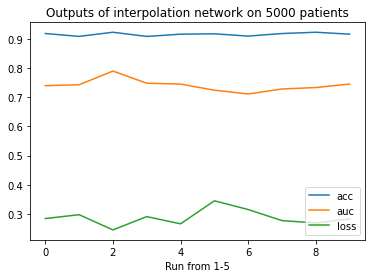

In [37]:
plt.plot(results['acc'], label='acc')
plt.plot(results['auc'], label='auc')
plt.plot(results['loss'], label='loss')
plt.legend(loc="lower right")
plt.title(f"Outputs of interpolation network on 5000 patients")
plt.xlabel("Run from 1-5")